# Model Fitting

In this notebook, we will try to fit a model to the data based on our findings in the first notebook.

We will make use of sklearn pipelines as well as custom transformers. To make this notebook shorter and easier to read, we put the code for the custom transformers as well as some functions to evaluate the models in a separate directory 'util/'.

Outline:

* [1 Baseline Models Without Feature Engineering](#baseline)
* [2 Models with Feature Engineering and Further Preprocessing](#feature_engineering_preprocessing)
    - [2.1 Comments](#comments)
* [3 Grid Search for Preprocessing Parameters](#gridsearch_preprocessing)
* [4 Grid Search for Model Parameters](#gridsearch_parameters)
* [5 Evaluate Best Model](#evaluate)


First, let's do the necessary imports:

In [1]:
import math
import pandas as pd
import numpy as np

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt

# Models
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Own stuff
from util.ML_eval import evaluate_on_training_set, evaluate_on_test_set
from util.custom_transformers import *

In [2]:
# define the standard plot size
plt.rcParams["figure.figsize"] = [10, 5]

# suppress warning
pd.options.mode.chained_assignment = None

Read the data and do a quick check:

In [3]:
input_file = 'data/hour.csv'
bike = pd.read_csv(input_file)
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [4]:
bike.round(2).head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.29,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.27,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.27,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.29,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.29,0.75,0.0,0,1,1


<a id = 'baseline'></a>
## 1 Baseline Models Without Feature Engineering

Here, we will run some plain models and perform minimum necessary or obvious preprocessing on our data, such that we can apply the models and get a baseline performance. These steps are:

1. Convert some columns to categorical.
2. Drop columns that are obviously not usable (here: 'instant', 'dteday' and 'atemp').
3. Perform one-hot encoding of the categorical features.

We will not do any additional feature engineering, scaling etc.
First, we split the data:

In [5]:
# Set random seed to make results reproducible and set test size to 10 %.
RANDOM_SEED = 23
TEST_RATIO = 0.1

# Features
X = bike.drop(["cnt", "casual", "registered"], axis = 1)
# Target
y = bike["cnt"]

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_RATIO, random_state = RANDOM_SEED)

In our first pipeline, we make use of three custom transformers:

* TypeSelector: selects certain data types.
* DropColumnsTransformer: drops columns that are not needed
* DTypeTransformer: converts certain columns to categorical data type
    
Our minimal pipeline looks as follows:

In [6]:
# get categorical data and perform OHE
categorical_pipeline = Pipeline([
    ('get_categorical', TypeSelector(['object', 'category', 'bool'])),
    ('OHE', OneHotEncoder(drop = 'first'))
])

# pass through all other columns unprocessed (otherwise they would be dropped)
rest_pipeline = Pipeline([
    ('get_rest', TypeSelector(exclude = ['object', 'category', 'bool']))
])

# put together the above pipelines
preprocessing_vanilla = Pipeline([
    # drop obviously useless
    ('drop_useless', DropColumnsTransformer(["instant", "dteday", "atemp"])),
    
    # convert to categorical
    ('to_categorical', DTypeTransformer(["season", "yr", "mnth", "hr", "holiday", "workingday", "weekday", "weathersit"])),
    
    # apply the two above pipelines in parallel
    ('union', FeatureUnion([
        ('categorical_pipeline', categorical_pipeline),
        ('rest_pipeline', rest_pipeline)
    ]))
    
])

A final pipeline contains a model as the last step. We use this function to conveniently put together such a pipeline:

In [7]:
def build_model(preprocessing, algo):
    model = Pipeline([
        ('preprocessing', preprocessing),
        ('model', algo)
    ])
    
    return model

Now we check three different algorithms:

1. Simple Linear Regression
2. Random Forest
3. Gradient Boosting

Remembering from before that a transformation of the dependent variable could be helpful (because of skewness),
we additionally run each model with a log-transformation:

In [9]:
# List of models
algos = [
    linear_model.LinearRegression(),
    RandomForestRegressor(n_jobs = -1, random_state = RANDOM_SEED),
    GradientBoostingRegressor(random_state = RANDOM_SEED)
]

# Evaluate each model with and without log-transformation
for algo in algos:
    
    model = build_model(preprocessing_vanilla, algo)
    
    # Basic model
    print("\n", "-" * 10, "Model:", algo.__class__.__name__, "-" * 10, "\n")
    print("Performance on training set:\n")    
    evaluate_on_training_set(model, X_train, y_train)
    
    # Model with log-transformation
    algo_log = TransformedTargetRegressor(regressor = algo, func = np.log1p, inverse_func = np.expm1)
    model_log = build_model(preprocessing_vanilla, algo_log)
    print("\nWith log-transform:\n")
    evaluate_on_training_set(model_log, X_train, y_train)


 ---------- Model: LinearRegression ---------- 

Performance on training set:

MAE (training): 69.83
RMSE (training): 98.69
MAE cross-validated (5 folds): 75.57

With log-transform:

MAE (training): 62.62
RMSE (training): 97.34
MAE cross-validated (5 folds): 62.86

 ---------- Model: RandomForestRegressor ---------- 

Performance on training set:

MAE (training): 12.13
RMSE (training): 19.44
MAE cross-validated (5 folds): 34.11

With log-transform:

MAE (training): 13.51
RMSE (training): 23.64
MAE cross-validated (5 folds): 37.25

 ---------- Model: GradientBoostingRegressor ---------- 

Performance on training set:

MAE (training): 57.04
RMSE (training): 79.50
MAE cross-validated (5 folds): 58.79

With log-transform:

MAE (training): 59.45
RMSE (training): 94.01
MAE cross-validated (5 folds): 60.23


Findings:

* The linear regression model is the only one positively affected by the log-transformation. The other two perform slightly worse.
* For linear regression and gradient boosting, the validation errors are very close to the training erros, which is a sign that we are not overfitting.
* For random forest, the validation error is much higher than the training error, so it is probably overfitting. However, the validation error is still lower than for the other two models, so we will proceed using this algorithm.

In [8]:
rf = RandomForestRegressor(n_jobs = -1, random_state = RANDOM_SEED)
model = build_model(preprocessing_vanilla, rf)

Performance on test set:

MAE: 32.54
RMSE: 54.48


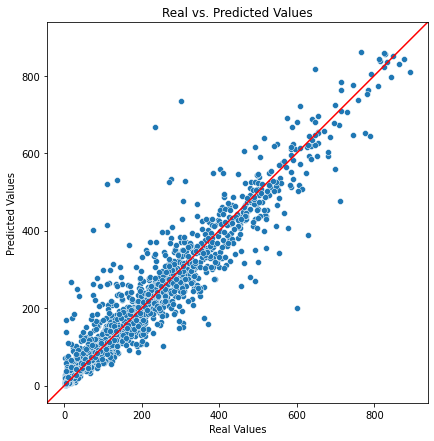

In [9]:
print("Performance on test set:\n")
evaluate_on_test_set(model, X_train, y_train, X_test, y_test)

This is not too bad, however, we are still significantly overfitting.
Next, we try to improve the random forest's performance by doing some feature engineering and  more preprocessing before fitting the model.

<a id = 'feature_engineering_preprocessing'></a>
## 2 Models with Feature Engineering and Further Preprocessing

In a next step, we will try to improve the most promising model from above, i.e., the random forest, by performing more feature engineering and preprocessing on our data. We will still use default parameters for the random forest.

First, we refine our preprocessing pipeline as follows:

1. Bin hours.
2. Bin years and months.
3. Do scaling.

The idea to bin hours and years/months is based on the findings in the exploratory data analysis (see first notebook).
We will create three bins for the hours: high (peak hours), medium and low.
Furthermore, we will bin years and months into quarters, to better capture the increasing trend over time. We also wrote a custom transformer to do the binning.

In a first step, we will not drop the original columns (hour, year, month).

In [10]:
# fetch numerical data and scale
numerical_pipeline = Pipeline([
    ('get_numerical', TypeSelector(np.number)),
    ('scale', StandardScaler())
])

# fetch categorical data and do OHE
categorical_pipeline = Pipeline([
    ('get_categorical', TypeSelector(['object', 'category', 'bool'])),
    ('OHE', OneHotEncoder(drop = 'first'))
])

# fetch the rest and pass it through
rest_pipeline = Pipeline([
    ('get_rest', TypeSelector(exclude = [np.number, 'object', 'category', 'bool']))
])

preprocessing = Pipeline([
    
    # binning of hours and year/month
    ('binning', BinningTransformer()),
    
    # drop obviously useless
    ('drop_useless', DropColumnsTransformer(["instant", "dteday", "atemp"])),
    
    # convert to categorical
    ('to_categorical', DTypeTransformer(["season", "yr", "mnth", "hr", "holiday", "workingday", "weekday", "weathersit"])),
    
    # run the above pipelines in parallel
    ('union', FeatureUnion([
        ('numerical_pipeline', numerical_pipeline),
        ('categorical_pipeline', categorical_pipeline),
        ('rest_pipeline', rest_pipeline)
    ]))
    
])

Evaluate again and check if we could improve:

In [11]:
rf = RandomForestRegressor(n_jobs = -1, random_state = RANDOM_SEED)
model = build_model(preprocessing, rf)

In [12]:
print("Performance on training set:\n")    
evaluate_on_training_set(model, X_train, y_train)

Performance on training set:

MAE (training): 9.60
RMSE (training): 15.96
MAE cross-validated (5 folds): 26.90


We improved quite a bit according to the CV score! Now let's check the performance on the actual test set again:

Performance on test set:

MAE: 26.35
RMSE: 45.72


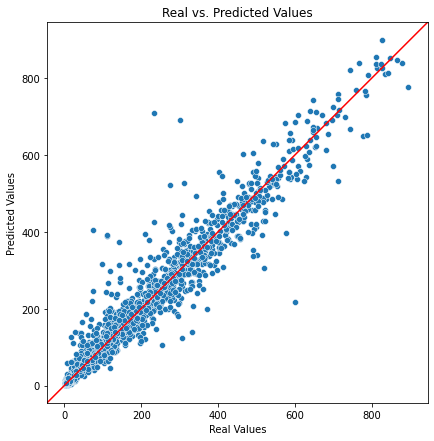

In [9]:
print("Performance on test set:\n")
evaluate_on_test_set(model, X_train, y_train, X_test, y_test)

Here we can also see quite a good improvement and we also see that the CV error estimated the performance on the test set correctly.

<a id = 'comments'></a>
### 2.1 Comments

* As we are predicting count data, it would be interesting to run a model like Poisson regression. However, this algorithm is not available within the sklearn framework, which we sticked to in this notebook for simplicity.
* Another possible approach is time series analysis.
* As we have seen that there is a difference between casual and registered users, one could try to estimate these two counts separately (i.e., building separate models) and then adding predictions up.

<a id = 'gridsearch_preprocessing'></a>
## 3 Grid Search for Preprocessing Parameters

A nice feature of sklearn pipelines is that you can perform a grid search not only for the model's hyperparameters but also any other parameter inside the pipeline. This way we can for example try to figure out whether it is a good idea to bin some variables or which ones we should drop.

In [ ]:
rf = RandomForestRegressor(n_jobs = -1, random_state = RANDOM_SEED)

# We use the preprocessing pipeline from above
model = build_model(preprocessing, rf)

In [10]:
parameters_preprocessing = {
    
    # Tune parameters of our preprocessing transformers
    'preprocessing__binning__bin_hours': [True, False],
    'preprocessing__binning__bin_year_month': [True, False],
    'preprocessing__drop_useless__drop_cols' : [
        ["instant", "dteday", "atemp"],
        ["instant", "dteday", "atemp", 'hr'],
        ["instant", "dteday", "atemp", 'yr', 'mnth'],
        ["instant", "dteday", "atemp", 'hr', 'yr', 'mnth']
    ]
}

The following grid search might have a long run time!

In [ ]:
grid_preprocessing = GridSearchCV(model, param_grid = parameters_preprocessing, cv = 5, scoring = 'neg_mean_absolute_error')
grid_preprocessing.fit(X_train, y_train)

print("Best MAE: %.2f" % -(grid_preprocessing.score(X_test, y_test)))
print("Found for the following parameters:")
print(grid_preprocessing.best_params_)

In [ ]:
print(grid_preprocessing.best_estimator_)

In case the code above didn't run (to save time). These are the best settings:

In [ ]:
# save the best preprocessing settings
best_params_preprocessing = {
    'preprocessing__binning__bin_hours': True,
    'preprocessing__binning__bin_year_month': True,
    'preprocessing__drop_useless__drop_cols': ['instant', 'dteday', 'atemp']
}

We see that our preprocessing pipeline already contained the best settings.

<a id = 'gridsearch_parameters'></a>
## 4 Grid Search for Model Parameters

We can tune the model's hyperparameters in the exact same way as we found the best preprocessing settings in the section above. As this has a long run time, we don't execute the code but just demonstrate how to do it.

Again, we can use the preprocessing pipeline defined above.

In [12]:
preprocessing = Pipeline([
    ('binning', BinningTransformer()),
    ('drop_useless', DropColumnsTransformer(["instant", "dteday", "atemp"])),
    ('to_categorical', DTypeTransformer(["season", "yr", "mnth", "hr", "holiday", "workingday", "weekday", "weathersit"])),
    ('union', FeatureUnion([
        ('numerical_pipeline', numerical_pipeline),
        ('categorical_pipeline', categorical_pipeline),
        ('rest_pipeline', rest_pipeline)
    ]))
])

Next, let's define the parameter grid we want to search. Naturally, it is important to think about how to design the grid. Here, we just try a few different values for three of the hyperparameters in order to demonstrate the process.

In [13]:
# tune model parameters
parameters_model = {
    'model__max_depth' : [40, 80, 120],
    'model__max_leaf_nodes' : [1000, 2000, 3000],
    'model__min_samples_split' : [3, 5, 7]
}

As a grid search like this might lead to long run times, we perform it on only 20 % of the data. This might not give us the best results, but we mainly do it for demonstration purposes:

In [15]:
data_small = bike.sample(n = math.floor(0.2 * bike.shape[0]), random_state = RANDOM_SEED) 

# Features
X_small = data_small.drop(["cnt", "casual", "registered"], axis = 1)
# Target
y_small = data_small["cnt"]

# Split into training and test set
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
    X_small, y_small, test_size = TEST_RATIO, random_state = RANDOM_SEED)

Perform the actual grid search and check the best parameters:

In [16]:
grid_model = GridSearchCV(model, param_grid = parameters_model, cv = 5, scoring = 'neg_mean_absolute_error')
grid_model.fit(X_train_small, y_train_small)

print("Best MAE: %.2f" % -(grid_model.score(X_test_small, y_test_small)))
print("Found for the following parameters:")
print(grid_model.best_params_)

Best MAE: 35.53
Found for the following parameters:
{'model__max_depth': 40, 'model__max_leaf_nodes': 1000, 'model__min_samples_split': 3}


<a id = 'evaluate'></a>
## 5 Evaluate Best Model

Let's check our model's performance plugging in the parameters found above:

In [18]:
rf = RandomForestRegressor(
    max_depth = 40,
    max_leaf_nodes = 1000,
    min_samples_split = 3,
    n_jobs = -1,
    random_state = RANDOM_SEED)

# We can still use the preprocessing pipeline from above (already contains the best parameters)
model = build_model(preprocessing, rf)

Performance on test set:

MAE: 27.69
RMSE: 46.55


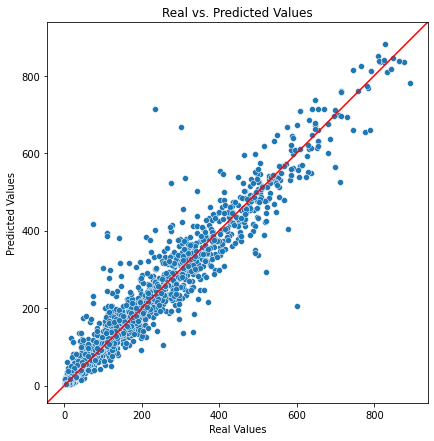

In [19]:
print("Performance on test set:\n")
evaluate_on_test_set(model, X_train, y_train, X_test, y_test)

The resuls is actually slightly worse than the one in section 2. However, this is probably due to the fact that:

1. We didn't really think deeply about the parameter grid.
2. We ran it on a smaller subset of the data.
    
A proper grid search will have a long run time.